In [1]:
# imports
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns",200)
sns.set_theme(style="whitegrid")

In [2]:
#  MySQL Credentials
HOST ="localhost"
USER="root"
PASSWORD="200717"
DB="CAPSTONE"
PORT=3306

In [3]:
# connect to MySQL
conn=mysql.connector.connect(
    host=HOST,
    user=USER,
    password=PASSWORD,
    database=DB,
    port=PORT
)
cursor = conn.cursor()
print("Coonected to MySQL:",DB)

Coonected to MySQL: CAPSTONE


In [4]:
def reu_sql_file(conn,cursor,sql_path):
    with open(sql_path, "r",encoding="utf-8") as f:
        sql = f.read()

    # Remove' '_ _' comment lines
    cleaned_lines =[]
    for line in sql.splitlines():
        if line.strip().startswith("--"):
            continue
        cleaned_lines.append(line)
        sql_clean ="\n".join(cleaned_lines)

    # split by ',' into statement
    statements=[s.strip() for s in sql_clean.split(";") if s.strip()]

    for stmt in statements:
        cursor.execute(stmr)
    conn.commit()
    print(f"SQL executed:{sql_path}")

In [5]:
# Read table into a pandas dataFrame
def read_table_to_df(cursor,table_name):
    cursor.execute(f"SELECT * FROM {table_name}")
    rows = cursor.fetchall()
    col_names = [desc[0] for desc in cursor.description]
    return pd.DataFrame(rows,columns=col_names)

In [6]:
# List Tables
cursor.execute("SHOW TABLES;")
table_names = [t[0] for t in cursor.fetchall()]
print("Tables in database:",table_names)

Tables in database: ['customers', 'fact_sales', 'order_items', 'orders', 'products']


In [7]:
#read all tables into DataFrame
dfs = {}
for t in table_names:
    dfs[t]=read_table_to_df(cursor,t)
    print(f"{t}: {dfs[t].shape[0]} rows x {dfs[t].shape[1]}cols")

customers = dfs.get("customers")
products = dfs.get("products")
orders = dfs.get("orders")
order_items = dfs.get("order_items")
fact = dfs.get("fact_sales")

customers: 970 rows x 7cols
fact_sales: 1225 rows x 25cols
order_items: 1225 rows x 10cols
orders: 520 rows x 10cols
products: 138 rows x 7cols


In [8]:
fact.to_csv("fact_sales_cleaned.csv",index=False)
print("Saved:fact_sales_cleaned.csv")
# Cell 13: Close connection
cursor.close()
conn.close()
print("MySQL connection closed")

Saved:fact_sales_cleaned.csv
MySQL connection closed


In [9]:
# CLEANING: USE FACT_SALES FOR ANALTICS
#  convert dates
# rename once
fact_sales = fact

# now use fact_sales everywhere
fact_sales["order_date"] = pd.to_datetime(fact_sales["order_date"],errors="coerce")
fact_sales["ship_date"] = pd.to_datetime(fact_sales["ship_date"],errors="coerce")

In [10]:
# handle missing values
fact["discount"] = fact["discount"].fillna(0)
fact["returned"] = fact["returned"].fillna(0).astype(int)
fact["segment"] = fact["returned"].fillna("UNKNOWN")

In [11]:
# drop rows missing critical fields
fact = fact.dropna(subset=["order_date","sales","profit"])

# Remove exact duplicate rows (Keep first)
fact = fact.drop_duplicates()

print("Cleaned fact_sales shape:",fact.shape)

Cleaned fact_sales shape: (1225, 25)


In [12]:
#Feature Engineering (Month,Qyarter,Profit Margin,Ship days)
fact["month_start"]=fact["order_date"].dt.to_period("M").dt.to_timestamp()
fact["month"]=fact["order_date"].dt.to_period("M").astype(str)
fact["quarter"]=fact["order_date"].dt.to_period("Q").astype(str)
fact['Year']=fact["order_date"].dt.year

fact["profit_margin"]=np.where(fact["sales"]==0,np.nan,fact["profit"]/fact["sales"])
fact["ship_days"]=(fact["ship_date"]-fact["order_date"]).dt.days

In [13]:
# Discount buckets for boxplot
fact["discount_bucket"] =pd.cut(
    fact["discount"],
    bins=[-0.001,0,0.05,0.10,0.20,1.0],
    labels=["0%","1-5%","6-10%","11-20%","20%+"]
)
fact.head()

,fact_id,order_id,order_item_id,order_date,ship_date,ship_mode,channel,customer_id,customer_name,segment,region,state,city,product_id,sku,brand,category,sub_category,quantity,sales,discount,shipping_cost,cogs,profit,returned,month_start,month,quarter,Year,profit_margin,ship_days,discount_bucket
0,1,O00079,OI000138,2024-06-28,2024-06-29,Second Class,Store,C0056,Charlotte Patel,0,East,Florida,miami,P0001,APP-MS-0001,Apple,Mobile,Smartphones,3,2796.21,0.00,10.12,1769.13,1016.96,0,2024-06-01,2024-06,2024Q2,2024,0.3636922834837154577088273055,1,0%
1,2,O00094,OI000610,2024-08-23,2024-08-29,Standard Class,Store,C0036,Isabella Reddy,0,East,Florida,Miami,P0001,APP-MS-0001,Apple,Mobile,Smartphones,1,792.26,0.15,6.74,589.71,195.81,0,2024-08-01,2024-08,2024Q3,2024,0.2471537121651982934895110191,6,11-20%
2,3,O00193,OI000671,2024-10-03,2024-10-09,First Class,Store,C0008,Ishaan Smith,0,Central,Minnesota,Minneapolis,P0001,APP-MS-0001,Apple,Mobile,Smartphones,3,2516.59,0.10,22.32,1769.13,725.14,0,2024-10-01,2024-10,2024Q4,2024,0.2881438772306970940836608268,6,6-10%
3,4,O00053,OI000758,2025-11-21,2025-11-25,Standard Class,Online,C0214,Charlotte Iyer,0,Central,ohio,Columbus,P0001,APP-MS-0001,Apple,Mobile,Smartphones,1,932.07,0.00,41.62,589.71,300.74,0,2025-11-01,2025-11,2025Q4,2025,0.3226581694507923224650509082,4,0%
4,5,O00350,OI000817,2025-03-29,2025-04-05,Same Day,Online,C0193,Mason Garcia,0,Central,Ohio,Columbus,P0001,APP-MS-0001,Apple,Mobile,Smartphones,1,932.07,0.00,20.30,589.71,322.06,0,2025-03-01,2025-03,2025Q1,2025,0.3455319879408198955014108382,7,0%


In [14]:
# Convert all relavant text columns to UPPERCASE
text_cols=[
    "customer_name",
    "segment",
    "region",
    "state",
    "city",
    "brand",
    "category",
    "sub_category",
    "ship_category",
    "ship_mode",
    "channel",
    "sku"
    
]

for col in text_cols:
    if col in fact_sales.columns:
        fact_sales[col] =(
            fact_sales[col]
            .astype(str)  # ensure string
            .str.strip() #remove space
            .str.upper() # convert to uppercase
            
        )

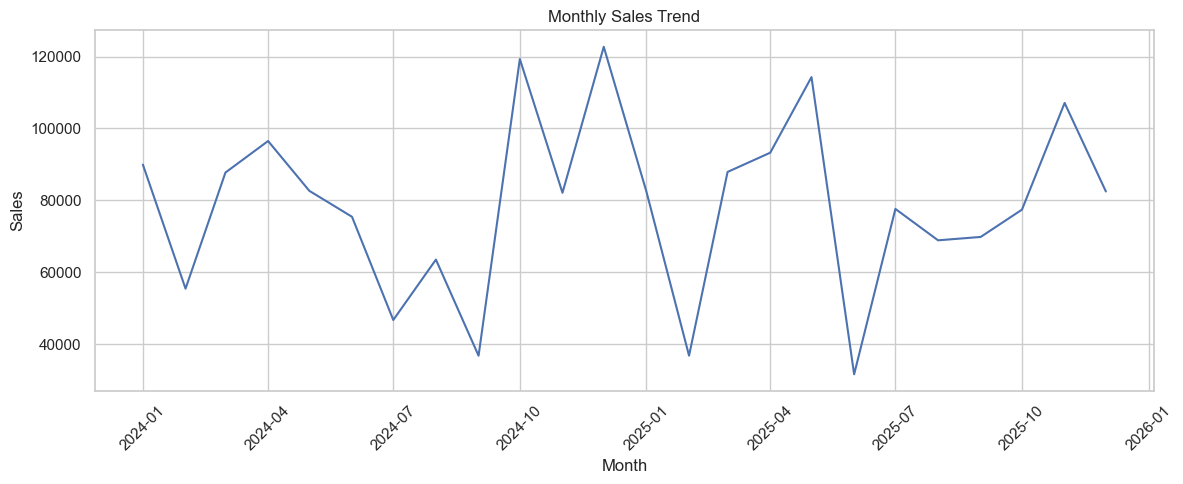

In [15]:
# EDA Starts
# sales trend (line chart)
monthly = (fact.groupby("month_start",as_index=False).agg(sales=("sales","sum"),profit=("profit","sum")))
plt.figure(figsize=(12,5))
plt.plot(monthly["month_start"],monthly["sales"])
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

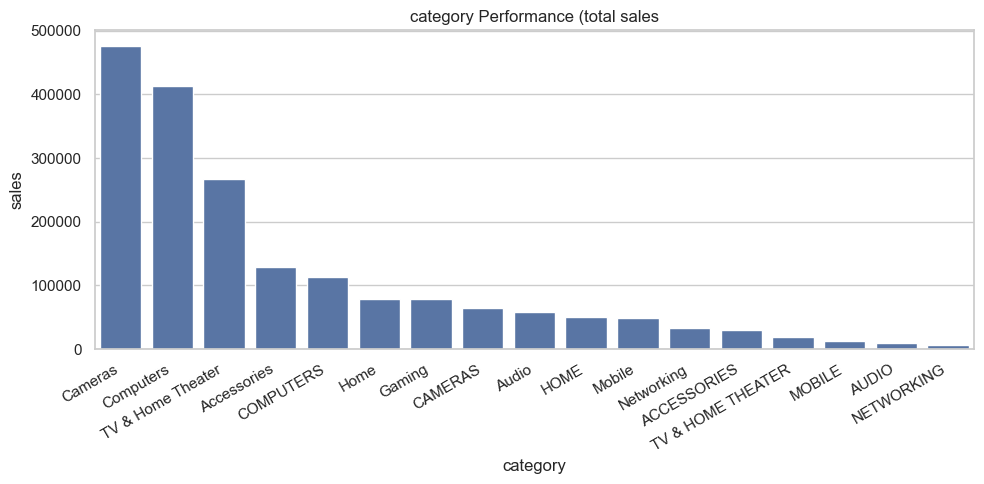

In [18]:
# Category performance (Bar Chart)
cat_perf =(fact.groupby("category", as_index=False).agg(sales=("sales","sum"),profit=("profit","sum")).sort_values("sales",ascending=False))
plt.figure(figsize=(10,5))
sns.barplot(data=cat_perf,x="category",y="sales",)
plt.title("category Performance (total sales")
plt.xlabel("category")
plt.ylabel("sales")
plt.xticks(rotation=30,ha="right")
plt.tight_layout()
plt.show()

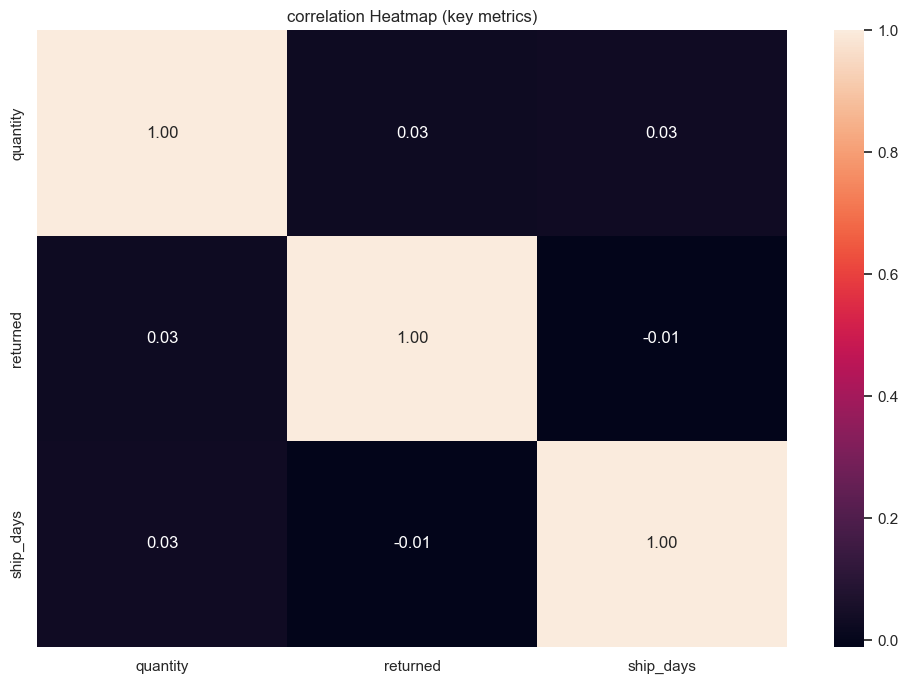

In [23]:
# correlation analysis (heatmap)
num_cols = ["quantity","discount","sales","shipping_cost","cogs","profit","returned","ship_days","profit_margin"]
corr = fact[num_cols].corr(numeric_only=True)
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot=True,fmt=".2f")
plt.title("correlation Heatmap (key metrics)")
plt.tight_layout()
plt.show()

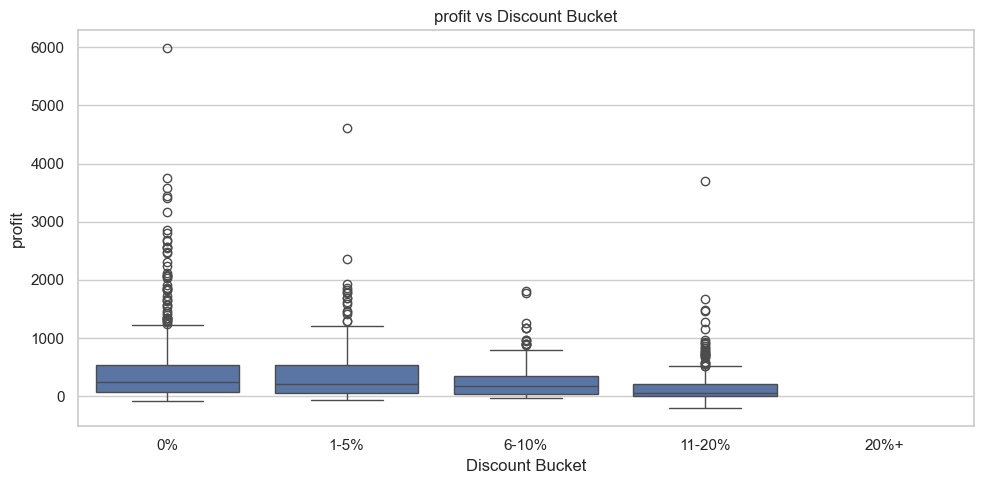

In [22]:
# profit vs Discount (box plot)
plt.figure(figsize=(10,5))
sns.boxplot(data=fact, x="discount_bucket",y="profit")
plt.title("profit vs Discount Bucket")
plt.xlabel("Discount Bucket")
plt.ylabel("profit")
plt.tight_layout()
plt.show()

In [24]:
fact.to_csv("fact_sales_cleaned.csv",index=False)
print("Saved:fact_sales_cleaned.csv")
# Cell 13: Close connection
cursor.close()
conn.close()
print("MySQL connection closed")

Saved:fact_sales_cleaned.csv
MySQL connection closed
